<a href="https://colab.research.google.com/github/bonly/AI/blob/main/deepseek_AI_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running Ollama on Google Colab and using LLM models for free
In this short tutorial we will discuss how we can harness the powers of Large Language Models (LLMs) without buying expensive laptops, computers and without burning a hole in your pocket.

Ollama makes it possible to leverage powerful large language models (LLMs) like mistral, llama3:2, deepseek-r1:7b etc. without needing a powerful expensive compute machine.

Google Colab’s provides a cloud environment perfectly suited for running these resource-intensive models. This guide meticulously details setting up and running Ollama on the free version of Google Colab, allowing you to explore the capabilities of LLMs without burning a hole in your pocket.

Steps needed to get Ollama up and running on Google Colab
Without wasting much time lets dive into the steps we need to perform to harness power of LLMs.

# Step 1: Install Packages
Installing and load modules in google colab notebook



```
!pip install colab-xterm #this will install colab-xterm
%load_ext colabxterm
```




# Step 2: Open terminal
After installing now we need to open terminal to access command line on google colab



```sh
%xterm
```


A terminal will open and you will see something similar in your notebook


Step 3: Install ollama
Run below command on the terminal to install Ollama

```sh
curl -fsSL https://ollama.com/install.sh | sh
```



Step 4: Pull the desired model
Ollama supports quiet a few models and a list of these can be found on there official website at below address: https://ollama.com/library Please type below command in the terminal

```sh
ollama serve & ollama pull deepseek-r1:7b
```

In [ ]:
!pip install colab-xterm
%load_ext colabxterm

In [11]:
%xterm

UsageError: Line magic function `%xterm` not found.


In [1]:
!pip install langchain langgraph yfinance langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.5/443.5 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.72
    Uninstalling langchain-core-0.3.72:
      Successfully uninstalled langchain-core-0.3.72


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Tuple, Annotated
from typing_extensions import TypedDict
import json

from langchain import PromptTemplate
from langchain.chains import LLMChain
from langchain.agents import AgentExecutor, Tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

In [4]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    symbol: str
    llm: ChatOpenAI
    results: Dict

In [5]:
# Initialize the ollama endpoint
def setup_llm():
    return ChatOpenAI(
        model="deepseek-r1:7b",
        api_key="ollama",
        base_url="http://127.0.0.1:11434/v1",
        temperature=0,
        top_p=0.7
    )

In [6]:
# Technical Analysis Node
def technical_analysis(state: State) -> State:
    """Node for technical analysis"""
    symbol = state["symbol"]
    llm = state["llm"]

    # Fetch technical data
    stock = yf.Ticker(symbol)
    hist = stock.history(period='1y')

    # Calculate indicators
    sma_20 = hist['Close'].rolling(window=20).mean()
    sma_50 = hist['Close'].rolling(window=50).mean()
    rsi = calculate_rsi(hist['Close'])

    data = {
        'current_price': hist['Close'].iloc[-1],
        'sma_20': sma_20.iloc[-1],
        'sma_50': sma_50.iloc[-1],
        'rsi': rsi.iloc[-1],
        'volume_trend': hist['Volume'].iloc[-5:].mean() / hist['Volume'].iloc[-20:].mean()
    }

    prompt = PromptTemplate.from_template(
        """Analyze these technical indicators for {symbol}:
        {data}

        Provide:
        1. Trend analysis
        2. Support/Resistance levels
        3. Technical rating (Bullish/Neutral/Bearish)
        4. Key signals
        """
    )

    chain = LLMChain(llm=llm, prompt=prompt)
    analysis = chain.run(symbol=symbol, data=json.dumps(data, indent=2))

    state["results"]["technical"] = {
        "data": data,
        "analysis": analysis
    }
    return state


In [8]:
# Market Analysis Node
def market_analysis(state: State) -> State:
    """Node for market analysis"""
    symbol = state["symbol"]
    llm = state["llm"]

    # Fetch market data
    stock = yf.Ticker(symbol)
    info = stock.info

    data = {
        'sector': info.get('sector', 'Unknown'),
        'industry': info.get('industry', 'Unknown'),
        'market_cap': info.get('marketCap', 0),
        'beta': info.get('beta', 1.0),
        'pe_ratio': info.get('trailingPE', 0)
    }

    prompt = PromptTemplate.from_template(
        """Analyze the market context for {symbol}:
        {data}

        Provide:
        1. Market sentiment
        2. Sector analysis
        3. Risk assessment
        4. Market outlook
        """
    )

    chain = LLMChain(llm=llm, prompt=prompt)
    analysis = chain.run(symbol=symbol, data=json.dumps(data, indent=2))

    state["results"]["market"] = {
        "data": data,
        "analysis": analysis
    }
    return state

# News Analysis Node
def news_analysis(state: State) -> State:
    """Node for news analysis"""
    symbol = state["symbol"]
    llm = state["llm"]

    # Fetch news
    stock = yf.Ticker(symbol)
    news = stock.news[:5]  # Last 5 news items

    news_data = [{
        'title': item.get('title', ''),
        'publisher': item.get('publisher', ''),
        'timestamp': datetime.fromtimestamp(item.get('providerPublishTime', 0)).strftime('%Y-%m-%d')
    } for item in news]

    prompt = PromptTemplate.from_template(
        """Analyze these recent news items for {symbol}:
        {news}

        Provide:
        1. Overall sentiment
        2. Key developments
        3. Potential impact
        4. Risk factors
        """
    )

    chain = LLMChain(llm=llm, prompt=prompt)
    analysis = chain.run(symbol=symbol, news=json.dumps(news_data, indent=2))

    state["results"]["news"] = {
        "data": news_data,
        "analysis": analysis
    }
    return state

# Final Recommendation Node
def generate_recommendation(state: State) -> State:
    """Node for final recommendation"""
    symbol = state["symbol"]
    llm = state["llm"]
    results = state["results"]

    prompt = PromptTemplate.from_template(
        """Based on the following analyses for {symbol}, provide a final recommendation:

        Technical Analysis:
        {technical}

        Market Analysis:
        {market}

        News Analysis:
        {news}

        Provide:
        1. Final recommendation (Strong Buy/Buy/Hold/Sell/Strong Sell)
        2. Confidence score (1-10)
        3. Key reasons
        4. Risk factors
        5. Target price range
        """
    )

    chain = LLMChain(llm=llm, prompt=prompt)
    final_recommendation = chain.run(
        symbol=symbol,
        technical=results["technical"]["analysis"],
        market=results["market"]["analysis"],
        news=results["news"]["analysis"]
    )

    state["results"]["recommendation"] = final_recommendation
    return state

def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    """Calculate RSI indicator"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def create_analysis_graph() -> StateGraph:
    """Create the analysis workflow graph"""
    # Create workflow graph
    workflow = StateGraph(State)

    # Add nodes
    workflow.add_node("technical", technical_analysis)
    workflow.add_node("market", market_analysis)
    workflow.add_node("news", news_analysis)
    workflow.add_node("recommendation", generate_recommendation)

    # Define edges
    workflow.add_edge("technical", "market")
    workflow.add_edge("market", "news")
    workflow.add_edge("news", "recommendation")
    workflow.add_edge(START, "technical")

    # Set end node
    workflow.add_edge("recommendation", END)


    return workflow.compile()

class StockAdvisor:
    def __init__(self):
        self.llm = setup_llm()
        self.graph = create_analysis_graph()

    def analyze_stock(self, symbol: str) -> Dict:
        """Run complete stock analysis"""
        print(f"\nAnalyzing {symbol}...")

        # Initialize state
        init_sate: State = {
            "symbol": symbol,
            "llm": self.llm,
            "results": {}
        }

        # Run analysis
        final_state = self.graph.invoke(init_sate)
        return final_state["results"]

# Helper function to run analysis
def run_analysis(symbol: str):
    """Run stock analysis and print results"""
    advisor = StockAdvisor()
    results = advisor.analyze_stock(symbol)

    print(f"\n=== Stock Analysis Report for {symbol} ===")

    print("\n=== Technical Analysis ===")
    print(results["technical"]["analysis"])

    print("\n=== Market Analysis ===")
    print(results["market"]["analysis"])

    print("\n=== News Analysis ===")
    print(results["news"]["analysis"])

    print("\n=== Final Recommendation ===")
    print(results["recommendation"])

    return results



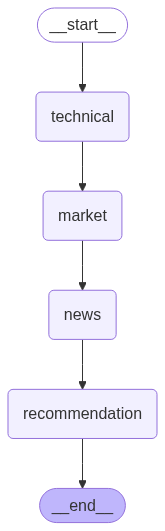

In [9]:
from IPython.display import Image, display

try:
    display(Image(create_analysis_graph().get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
# Example usage:
results = run_analysis("INFY.NS")


Analyzing INFY.NS...

=== Stock Analysis Report for INFY.NS ===

=== Technical Analysis ===
<think>
Okay, so I need to analyze these technical indicators for INFY.NS. Let me go through each part step by step.

First, the current price is 1423.0999755859375. The SMA_20 is 1524.804998779297, and SMA_50 is 1572.0760034179686. RSI is around 10.06, and volume_trend is approximately 1.1968.

Starting with trend analysis. The current price is below both the 20-day and 50-day SMAs. Since SMAs are moving averages that help identify trends, if the price is below them, it suggests a downward trend. So I think the overall trend is bearish here.

Next, support and resistance levels. The SMA_20 acts as a shorter-term support/resistance level. If the price is above SMA_20, it's bullish; below, bearish. Here, it's below, so maybe SMA_20 could be acting as resistance? Wait, no, usually SMAs are used to identify support or resistance based on their position relative to the current price. Since the pric